In [1]:
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
np.random.seed(0)
X = 2*np.random.uniform(size=(10000,2)) - 1
Y = np.zeros(10000)
for i,x in enumerate(X):
    if x[0]*x[1]<0:
        Y[i] = 1
        
print(X[:5])
print(Y[:5])

[[ 0.09762701  0.43037873]
 [ 0.20552675  0.08976637]
 [-0.1526904   0.29178823]
 [-0.12482558  0.783546  ]
 [ 0.92732552 -0.23311696]]
[0. 0. 1. 1. 1.]


In [3]:
tsfm = StandardScaler()

X_train ,X_test, y_train, y_test = train_test_split(X,Y,train_size=0.7)
X_test,X_val, y_test, y_val = train_test_split(X_test,y_test,train_size=0.5)

X_train = tsfm.fit_transform(X_train)
X_test = tsfm.fit_transform(X_test)
X_val = tsfm.fit_transform(X_val)

#print(np.mean(X_val),np.std(X_val))

In [4]:
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))


class testData(Dataset):
    
    def __init__(self, X_data,y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test),torch.FloatTensor(y_test))
val_data = testData(torch.FloatTensor(X_val),torch.FloatTensor(y_val))

In [5]:
print(len(train_data))
print(len(test_data))
print(len(val_data))

7000
1500
1500


In [6]:
BATCH_SIZE = 16

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE)

val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE)

In [7]:
for a,b in train_loader:
    print(a,b)
    break

tensor([[-0.1138, -1.0466],
        [-1.5909, -0.8159],
        [ 0.5969,  0.9799],
        [-0.3961,  1.0636],
        [-1.4274,  1.0819],
        [ 1.4694,  1.3594],
        [ 0.2008, -0.8394],
        [ 1.5294, -0.4781],
        [ 0.2774,  0.1944],
        [ 1.4456,  0.8061],
        [-0.8915, -0.5580],
        [-0.0035,  0.3931],
        [-0.8021, -1.5632],
        [-0.5946, -0.2835],
        [-1.6121, -0.2927],
        [-1.0471, -0.5019]]) tensor([0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.])


In [8]:
class MyNet(nn.Module):
    def __init__(self,hidden=8):
        super(MyNet, self).__init__()        # Number of input features is 12.
        self.layer_1 = nn.Linear(2, hidden) 
        self.layer_2 = nn.Linear(hidden, 1)
        #self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        #self.batchnorm1 = nn.BatchNorm1d(hidden)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        #x = self.batchnorm1(x)
        x = self.layer_2(x)
        x = torch.sigmoid(x)
        
        return x

In [9]:
model = MyNet()
print(model)

MyNet(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)


In [10]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [11]:
LEARNING_RATE = 0.005



In [12]:
def plot_loss(train_losses,val_losses,loss_cr):
    plt.plot(train_losses,label = "Train")
    plt.plot(val_losses, label = "Validation")
    plt.legend()
    plt.title("Losses after epochs "+loss_cr)
    plt.xlabel("Epochs")
    plt.ylabel("Loss values")
    plt.show()
    
def plot_accuracies(train_acc,val_acc,loss_cr):
    plt.plot(train_acc, label = "Train")
    plt.plot(val_acc, label = "Validation")
    plt.title("Accuracies after epochs "+loss_cr)
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

In [29]:
EPOCHS = 100

device = 'cpu'

def trainer_function(loss_cr,learning_rate,epochs,plot=True,hidden=4):
    
    
    EPOCHS = epochs
    LEARNING_RATE = learning_rate
    ######## Resetting model so that the two loss functions can be verified separately########
    model = MyNet(hidden)
    print(model)
    if loss_cr=='BCE':
        criterion = nn.BCELoss()

    elif loss_cr=='MSE':
        criterion = nn.MSELoss()

    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0)
    #######
    
    
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for e in range(1, EPOCHS+1):

        model.train()
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X_batch)
            #print(y_pred.size(),y_batch.unsqueeze(1).size())
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

        train_accuracies.append(epoch_acc/len(train_loader))
        train_losses.append(epoch_loss/len(train_loader))
        if (e+1)%5==0:
            print(f'Train Accuracy | Epoch {e+1:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_acc = 0
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)

                y_predval = model(X_val)
                loss = criterion(y_predval,y_val.unsqueeze(1))
                acc = binary_acc(y_predval, y_val.unsqueeze(1))

                val_loss += loss.item()
                val_acc += acc

        val_accuracies.append(val_acc/len(val_loader))
        val_losses.append(val_loss/len(val_loader))
        if (e+1)%5==0:
            print(f'Valid Accuracy | Epoch {e+1:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}\n')

    #plotter
    if plot:
        plot_loss(train_losses,val_losses,loss_cr)
        plot_accuracies(train_accuracies,val_accuracies,loss_cr)
    return val_losses

****************************************************************************************************
Loss criterion is MSE
****************************************************************************************************
MyNet(
  (layer_1): Linear(in_features=2, out_features=4, bias=True)
  (layer_2): Linear(in_features=4, out_features=1, bias=True)
  (relu): ReLU()
)
Train Accuracy | Epoch 005: | Loss: 0.11026 | Acc: 89.386
Valid Accuracy | Epoch 005: | Loss: 0.11026 | Acc: 89.386

Train Accuracy | Epoch 010: | Loss: 0.05862 | Acc: 94.324
Valid Accuracy | Epoch 010: | Loss: 0.05862 | Acc: 94.324

Train Accuracy | Epoch 015: | Loss: 0.04342 | Acc: 95.842
Valid Accuracy | Epoch 015: | Loss: 0.04342 | Acc: 95.842

Train Accuracy | Epoch 020: | Loss: 0.03589 | Acc: 96.543
Valid Accuracy | Epoch 020: | Loss: 0.03589 | Acc: 96.543

Train Accuracy | Epoch 025: | Loss: 0.03106 | Acc: 96.957
Valid Accuracy | Epoch 025: | Loss: 0.03106 | Acc: 96.957

Train Accuracy | Epoch 030: | Loss: 0.027

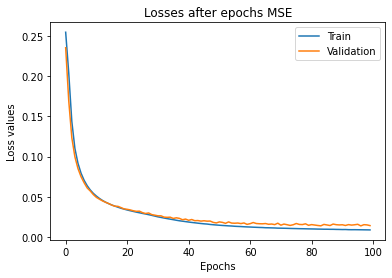

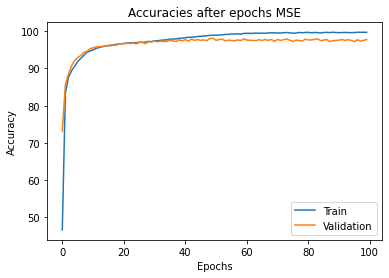

****************************************************************************************************
Loss criterion is BCE
****************************************************************************************************
MyNet(
  (layer_1): Linear(in_features=2, out_features=4, bias=True)
  (layer_2): Linear(in_features=4, out_features=1, bias=True)
  (relu): ReLU()
)
Train Accuracy | Epoch 005: | Loss: 0.26899 | Acc: 91.977
Valid Accuracy | Epoch 005: | Loss: 0.26899 | Acc: 91.977

Train Accuracy | Epoch 010: | Loss: 0.11830 | Acc: 97.916
Valid Accuracy | Epoch 010: | Loss: 0.11830 | Acc: 97.916

Train Accuracy | Epoch 015: | Loss: 0.08158 | Acc: 99.041
Valid Accuracy | Epoch 015: | Loss: 0.08158 | Acc: 99.041

Train Accuracy | Epoch 020: | Loss: 0.06617 | Acc: 99.354
Valid Accuracy | Epoch 020: | Loss: 0.06617 | Acc: 99.354

Train Accuracy | Epoch 025: | Loss: 0.05704 | Acc: 99.575
Valid Accuracy | Epoch 025: | Loss: 0.05704 | Acc: 99.575

Train Accuracy | Epoch 030: | Loss: 0.050

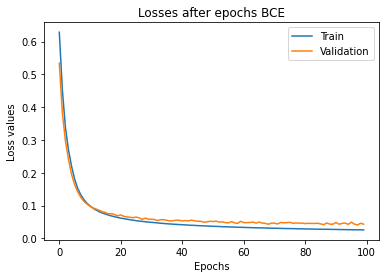

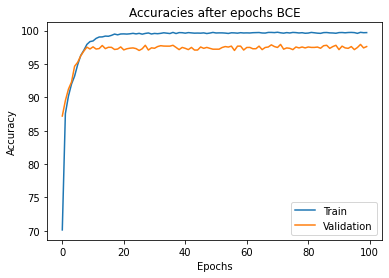

In [22]:
for loss_cr in ['MSE','BCE']:
    print('*'*100)
    print("Loss criterion is "+loss_cr)
    print('*'*100)
    trainer_function(loss_cr,0.005,100,plot=True,hidden=4)

From the graphs we observe that Binary Cross Entropy loss function makes the loss converge faster than Mean Squared Error. Hence, for the further parts of the assignment I have used Binary Cross Entropy as the loss function.

In [23]:
val_losses_hidden = []
loss_cr = 'BCE'
for hidden in [2,4,6,8,10]:
    val_losses_hidden.append(trainer_function(loss_cr,0.025,40,plot=False,hidden=hidden))
    
#print(val_losses_hidden)

MyNet(
  (layer_1): Linear(in_features=2, out_features=2, bias=True)
  (layer_2): Linear(in_features=2, out_features=1, bias=True)
  (relu): ReLU()
)
Train Accuracy | Epoch 005: | Loss: 0.49662 | Acc: 68.966
Valid Accuracy | Epoch 005: | Loss: 0.49662 | Acc: 68.966

Train Accuracy | Epoch 010: | Loss: 0.45014 | Acc: 70.694
Valid Accuracy | Epoch 010: | Loss: 0.45014 | Acc: 70.694

Train Accuracy | Epoch 015: | Loss: 0.43411 | Acc: 72.466
Valid Accuracy | Epoch 015: | Loss: 0.43411 | Acc: 72.466

Train Accuracy | Epoch 020: | Loss: 0.42521 | Acc: 71.550
Valid Accuracy | Epoch 020: | Loss: 0.42521 | Acc: 71.550

Train Accuracy | Epoch 025: | Loss: 0.41943 | Acc: 72.377
Valid Accuracy | Epoch 025: | Loss: 0.41943 | Acc: 72.377

Train Accuracy | Epoch 030: | Loss: 0.41499 | Acc: 72.299
Valid Accuracy | Epoch 030: | Loss: 0.41499 | Acc: 72.299

Train Accuracy | Epoch 035: | Loss: 0.41121 | Acc: 72.541
Valid Accuracy | Epoch 035: | Loss: 0.41121 | Acc: 72.541

Train Accuracy | Epoch 040: | L

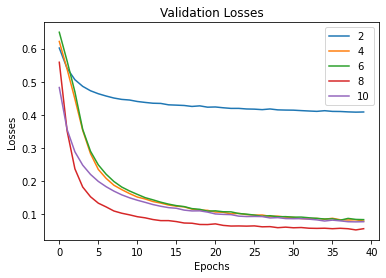

In [25]:
hidden_layers = [2,4,6,8,10]

for i,x in enumerate(val_losses_hidden):
    plt.plot(x,label = hidden_layers[i])
    
plt.title("Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()

Hence we can see that hidden layer size of 8 fives the best result.

In [30]:
val_losses_hidden = []
loss_cr = 'BCE'
learning_rates = [1e-5,1e-4,1e-3,1e-2,1e-1]
for lr in learning_rates:
    print('*'*100)
    print("Learning Rate = "+ str(lr))
    print('*'*100)
    val_losses_hidden.append(trainer_function(loss_cr,lr,40,plot=False,hidden=8))
    
#print(val_losses_hidden)

****************************************************************************************************
Learning Rate = 1e-05
****************************************************************************************************
MyNet(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)
Train Accuracy | Epoch 005: | Loss: 0.68257 | Acc: 51.016
Valid Accuracy | Epoch 005: | Loss: 0.68257 | Acc: 51.016

Train Accuracy | Epoch 010: | Loss: 0.68227 | Acc: 51.034
Valid Accuracy | Epoch 010: | Loss: 0.68227 | Acc: 51.034

Train Accuracy | Epoch 015: | Loss: 0.68190 | Acc: 51.071
Valid Accuracy | Epoch 015: | Loss: 0.68190 | Acc: 51.071

Train Accuracy | Epoch 020: | Loss: 0.68157 | Acc: 51.130
Valid Accuracy | Epoch 020: | Loss: 0.68157 | Acc: 51.130

Train Accuracy | Epoch 025: | Loss: 0.68132 | Acc: 51.078
Valid Accuracy | Epoch 025: | Loss: 0.68132 | Acc: 51.078

Train Accuracy | Epoch 030: | Loss: 0.680

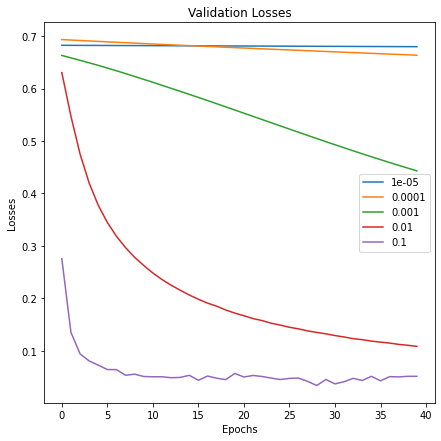

In [31]:
plt.figure(figsize=(7,7))

for i,x in enumerate(val_losses_hidden):
    plt.plot(x,label = learning_rates[i])
    
plt.title("Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()

Learing rates of 0.1 gives best results, however if we are allowed to increase the number of epochs 0.01 may give better results as it converges smoothly to the minimum.
    learning_rate = 0.1
    hidden_layers = 8

In [32]:
model = MyNet(8)
LEARNING_RATE = 0.1
EPOCHS = 100
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0)


print(model)


train_accuracies=[]
train_losses = []
##training our final model##
for e in range(1, EPOCHS+1):

        model.train()
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X_batch)
            #print(y_pred.size(),y_batch.unsqueeze(1).size())
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

        train_accuracies.append(epoch_acc/len(train_loader))
        train_losses.append(epoch_loss/len(train_loader))
        if (e+1)%5==0:
            print(f'Train Accuracy | Epoch {e+1:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')



MyNet(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)
Train Accuracy | Epoch 005: | Loss: 0.08387 | Acc: 98.644
Train Accuracy | Epoch 010: | Loss: 0.04783 | Acc: 99.205
Train Accuracy | Epoch 015: | Loss: 0.03722 | Acc: 99.329
Train Accuracy | Epoch 020: | Loss: 0.03124 | Acc: 99.356
Train Accuracy | Epoch 025: | Loss: 0.02817 | Acc: 99.411
Train Accuracy | Epoch 030: | Loss: 0.02607 | Acc: 99.438
Train Accuracy | Epoch 035: | Loss: 0.02401 | Acc: 99.463
Train Accuracy | Epoch 040: | Loss: 0.02272 | Acc: 99.411
Train Accuracy | Epoch 045: | Loss: 0.02101 | Acc: 99.548
Train Accuracy | Epoch 050: | Loss: 0.02005 | Acc: 99.589
Train Accuracy | Epoch 055: | Loss: 0.01951 | Acc: 99.425
Train Accuracy | Epoch 060: | Loss: 0.01911 | Acc: 99.425
Train Accuracy | Epoch 065: | Loss: 0.01810 | Acc: 99.438
Train Accuracy | Epoch 070: | Loss: 0.01755 | Acc: 99.507
Train Accuracy | Epoch 075: | Loss: 0.

tensor(99.1702)


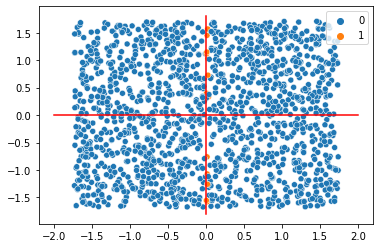

The number of wrong predictions are: 13


In [45]:
import seaborn as sns

model.eval()

y_predictions = []
points_x = []
points_y = []
with torch.no_grad():
    val_loss = 0
    val_acc = 0
    #although variable is X_val it is derived from the test_loader dataloader(test dataset)
    for X_val, y_val in test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)

        y_predval = model(X_val)
        for out in y_predval:
            y_predictions.append(np.round(float(out)))
        for point in X_val:
            points_x.append(np.array(point)[0])
            points_y.append(np.array(point)[1])
            
        loss = criterion(y_predval,y_val.unsqueeze(1))
        acc = binary_acc(y_predval, y_val.unsqueeze(1))

        val_loss += loss.item()
        val_acc += acc
    val_acc = val_acc/len(test_loader)    
    
    
print(val_acc)
labels = []

for X_val,y_val in test_loader:
    for label in y_val:
        labels.append(float(label))
        
xrange = range(len(labels))
#we shall plot the points where the two label dont match
counter = 0
mismatch = [0]*len(y_predictions)
for k,(i,j) in enumerate(zip(y_predictions,labels)):
    if i==j:
        mismatch[k]=0
    else:
        counter+=1
        mismatch[k]=1

sns.scatterplot(x=points_x,y=points_y,hue=mismatch)
plt.plot([-2,2],[0,0],color='red')
plt.plot([0,0],[-1.8,1.8],color='red')
plt.show()
        
print("The number of wrong predictions are: "+str(counter))

Hence we can see that our model makes an error only in the critical cases. i.e. when the points are in the boundary of the decision plane of the classifier. Blue points are the correctly classified points whereas the orange ones are wrongly classified.